In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

warnings.filterwarnings('ignore')

# a bit setup
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
def load_yeast_data(data_path = './data/yeast.data'):
    file = open(data_path)
    lines = file.readlines()
    file.close()
    X = []
    y = []
    label_dict = {}
    id = 0
    for line in lines:
        line = line.split()
        if (len(line) == 0): # skip empty line
            continue
        X.append([float(attr) for attr in line[1 : -1]])
        label = line[-1]
        # convert label to integer
        if (label in label_dict):
            y.append(label_dict[label])
        else:
            label_dict[label] = id
            y.append(id)
            id += 1
    label_dict = {i : key for i, key in enumerate(label_dict)}
    return np.array(X), np.array(y), label_dict

# load data from disk
X, y, label_dict = load_yeast_data()
assert X.shape[0] == y.shape[0], 'data mismatch'
print("%d instances loaded" % (X.shape[0],))
print("%d labels in total" % (len(label_dict),))

1484 instances loaded
10 labels in total


In [80]:
# see some data examples
idx = np.random.randint(0, X.shape[0], 3)
for i in idx:
    print("{} --> {}".format(X[i], label_dict[y[i]]))

print('data shape:', X.shape, y.shape)

[0.5  0.62 0.54 0.66 0.5  0.   0.49 0.22] --> MIT
[0.25 0.41 0.47 0.14 0.5  0.   0.56 0.68] --> NUC
[0.91 0.77 0.34 0.47 0.5  0.   0.52 0.31] --> ME1
data shape: (1484, 8) (1484,)


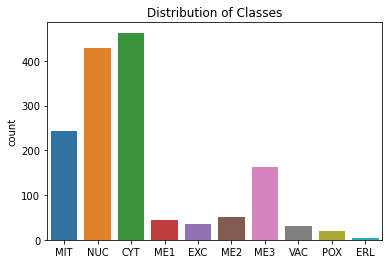

In [81]:
# see distribution of the labels
ax = sns.countplot(x = [label_dict[i] for i in y])
ax.set_title('Distribution of Classes');

In [82]:
# the distribution is imbalance, but we'll use logistic regression directly anyway
N = X.shape[0]
idx = list(range(N))
np.random.shuffle(idx)

# 2/3 for training(include validation), 1/3 for test
X_train, y_train = X[idx[: int(N * 0.67)], :], y[idx[: int(N * 0.67)]]
X_test, y_test = X[idx[int(N * 0.67) :], :], y[idx[int(N * 0.67) :]]

print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (994, 8) (994,)
test: (490, 8) (490,)


In [83]:
%%time
# this block implements training for OvO classification

n_classes = len(label_dict)

# split again for validation
n_train = X_train.shape[0]
X_train_ovo, y_train_ovo = X_train[: int(n_train * 0.8), :], y_train[: int(n_train * 0.8)]
X_val_ovo, y_val_ovo = X_train[int(n_train * 0.8) :, :], y_train[int(n_train * 0.8) :]
print('train set for OvO:', X_train_ovo.shape, y_train_ovo.shape)
print('val set for OvO:', X_val_ovo.shape, y_val_ovo.shape)

# fetch the data pair
def fetch_ovo_binary(X, y, pos_class, neg_class):
    X_selected = []
    y_selected = []
    for i in y:
        if (i == pos_class or i == neg_class):
            X_selected.append(X[i, :])
            y_selected.append(1 if i == pos_class else 0)
    return np.array(X_selected), np.array(y_selected)

# set some hyperparameters
# weight_decay_inv = [0.1, 1, 10]
regular_inv = 0.1

# get all classifiers
classifiers = []
for pos_class in range(0, n_classes - 1):
    for neg_class in range(pos_class + 1, n_classes):
        X_selected, y_selected = fetch_ovo_binary(X_train_ovo, y_train_ovo, pos_class, neg_class)
        model = LogisticRegression(C = regular_inv, class_weight = None, solver = 'lbfgs', multi_class = 'auto')
        model.fit(X_selected, y_selected)
        # add to the classifiers
        classifiers.append((model, pos_class, neg_class))
print("%d classifiers trained." % (len(classifiers),))

# compute the predicted labels
def ovo_predict(X):
    cnt = np.zeros((X.shape[0], n_classes))
    # try each classifier
    for estimator, pos_class, neg_class in classifiers:
        y = estimator.predict(X)
        cnt[: , pos_class] += y
        cnt[: , neg_class] += (1 - y)
    return np.argmax(cnt, axis = 1)

# compute validation score
y_predict = ovo_predict(X_val_ovo)
print('validation score:', np.sum(y_predict == y_val_ovo) / X_val_ovo.shape[0])

train set for OvO: (795, 8) (795,)
val set for OvO: (199, 8) (199,)
45 classifiers trained.
validation score: 0.3417085427135678
CPU times: user 107 ms, sys: 3.84 ms, total: 110 ms
Wall time: 108 ms


In [84]:
# evaluate once on the test data
y_predict = ovo_predict(X_test)
print('Accuracy: %.3f' % (np.sum(y_predict == y_test) / X_test.shape[0],))

Accuracy: 0.335


In [85]:
%%time
# this block implements the OvR classification

# set some parameters
regular_inv = 20

best_score = float('-inf')
best_classifier = None

results = cross_validate(LogisticRegression(C = regular_inv, class_weight = None, solver = 'lbfgs', multi_class = 'ovr'), 
                        X_train, y_train, cv = 3, return_estimator = True)
idx = np.argmax(results['test_score'])
max_score = results['test_score'][idx]
if (max_score > best_score):
    best_score = max_score
    best_classifier = results['estimator'][idx]

print("best validation score: %.3f" % (best_score,))

best validation score: 0.593
CPU times: user 191 ms, sys: 7.49 ms, total: 199 ms
Wall time: 198 ms


In [86]:
# evaluate once on the test data
y_predict = best_classifier.predict(X_test)
print("Accuracy: %.3f" % (np.sum(y_predict == y_test) / X_test.shape[0],))

Accuracy: 0.578


In [87]:
%%time
# this block implements the multi-class logistic regression 

# scale the data first
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_train_scaled = (X_train - X_mean) / X_std

# set some parameters
regular_inv = 1

best_score = float('-inf')
best_classifier = None

results = cross_validate(LogisticRegression(C = regular_inv, class_weight = None, solver = 'lbfgs', multi_class = 'multinomial', tol = 0.01, max_iter = 200), 
                        X_train_scaled, y_train, cv = 3, return_estimator = True)
idx = np.argmax(results['test_score'])
max_score = results['test_score'][idx]
if (max_score > best_score):
    best_score = max_score
    best_classifier = results['estimator'][idx]

print("best validation score: %.3f" % (best_score,))

best validation score: 0.604
CPU times: user 119 ms, sys: 255 µs, total: 119 ms
Wall time: 119 ms


In [88]:
# evaluate once on the test data
X_test_scaled = (X_test - X_mean) / X_std
y_predict = best_classifier.predict(X_test_scaled)
print('Accuracy:', np.sum(y_predict == y_test) / X_test_scaled.shape[0])

Accuracy: 0.5755102040816327
